In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("planilhas/dfRegressaoDias.csv", sep=';', parse_dates=['Data'], index_col="Data")
display(df)
df.info()

split = int(0.7 * len(df))


X_treino = df[:split].index
X_teste = df[split:].index

Y_treino = df[:split].values
Y_teste = df[split:].values

,CasosDia
Data,
2020-03-15,3
2020-03-16,3
2020-03-17,3
2020-03-18,1
2020-03-19,0
...,...
2023-09-24,0
2023-09-25,13
2023-09-26,14


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1293 entries, 2020-03-15 to 2023-09-28
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CasosDia  1293 non-null   int64
dtypes: int64(1)
memory usage: 20.2 KB


# Média Móvel

905
388
905
388


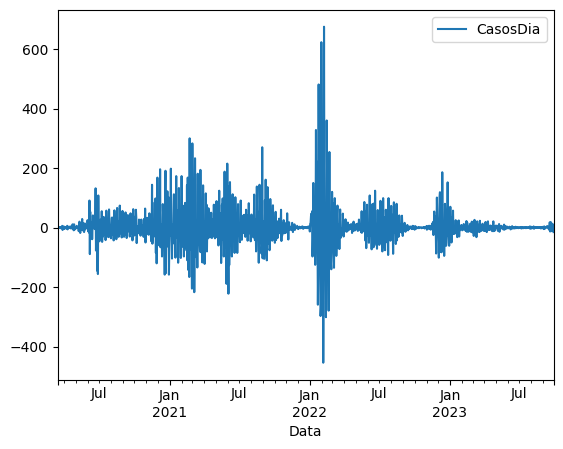

In [5]:
df.diff().plot() 
print(len(X_treino))
print(len(X_teste))
print(len(Y_treino))
print(len(Y_teste))



In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:                               
    
  total_len = train_len + horizon
  
  if method == 'mean':
      pred_mean = []
      
      for i in range(train_len, total_len, window):
          mean = np.mean(df[:i].values)
          pred_mean.extend(mean for _ in range(window))

      return pred_mean

  elif method == 'last':
      pred_last_value = []
      
      for i in range(train_len, total_len, window):
          last_value = df[:i].iloc[-1].values[0]
          pred_last_value.extend(last_value for _ in range(window))
      return pred_last_value
  
  elif method == 'MA':  # MA de ordem Q
      pred_MA = []
      
      for i in range(train_len, total_len, window):
          model = SARIMAX(df[:i], order=(0,0,2))                  
          res = model.fit(disp=False)
          predictions = res.get_prediction(0, i + window - 1)
          oos_pred = predictions.predicted_mean.iloc[-window:]    
          pred_MA.extend(oos_pred)
          
      return pred_MA

janela = 2
pred = rolling_forecast(df, len(Y_treino), len(Y_teste), janela, 'last')



12.37


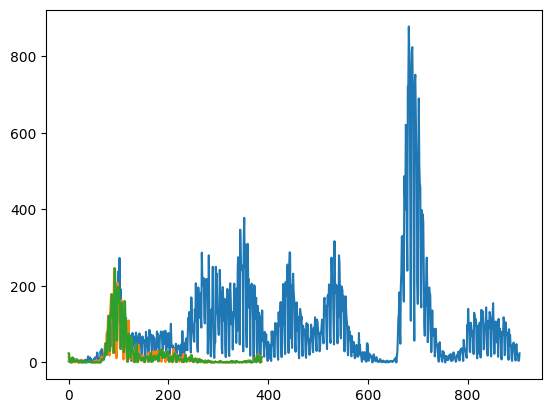

In [7]:
plt.plot(Y_treino)
plt.plot(Y_teste)
plt.plot(pred)

mae = mean_absolute_error(Y_teste, pred).round(2)




print(mae)

!! ULTIMO VALOR (20) É A MÉDIA !!!


,PARA,MAE,MSE,RMSE
0,3,19.29,1608.27,40.1
1,3,19.29,1608.27,40.1
2,3,19.29,1608.27,40.1
3,3,19.29,1608.27,40.1
4,3,19.29,1608.27,40.1
5,3,19.29,1608.27,40.1
6,3,19.29,1608.27,40.1
7,3,19.29,1608.27,40.1
8,3,19.29,1608.27,40.1
9,3,19.29,1608.27,40.1


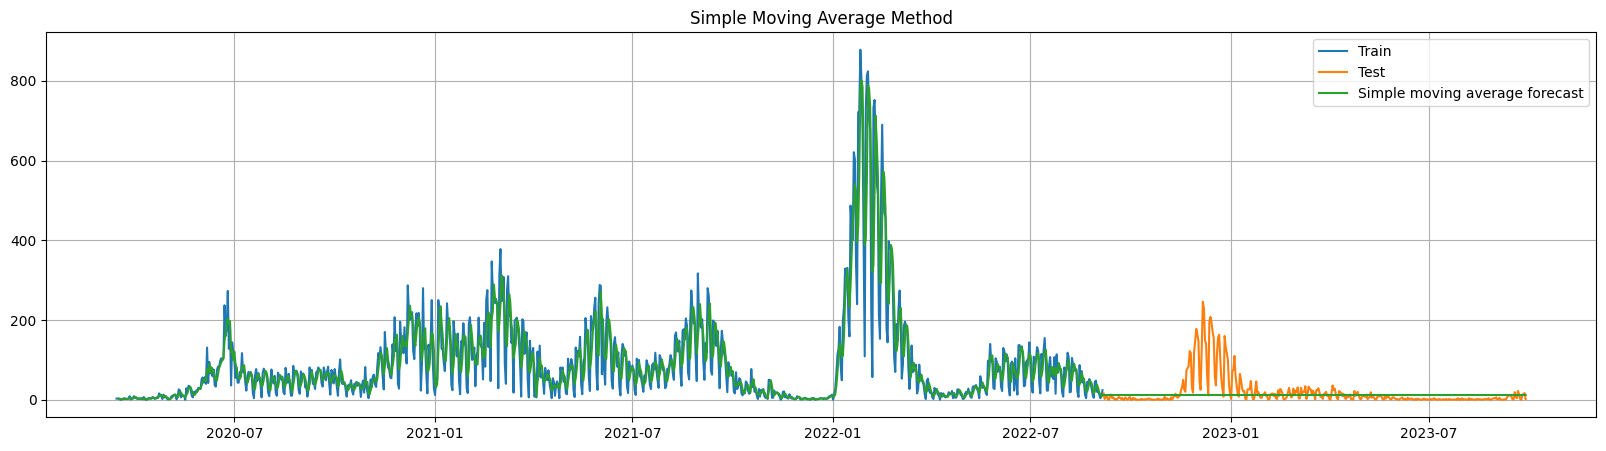

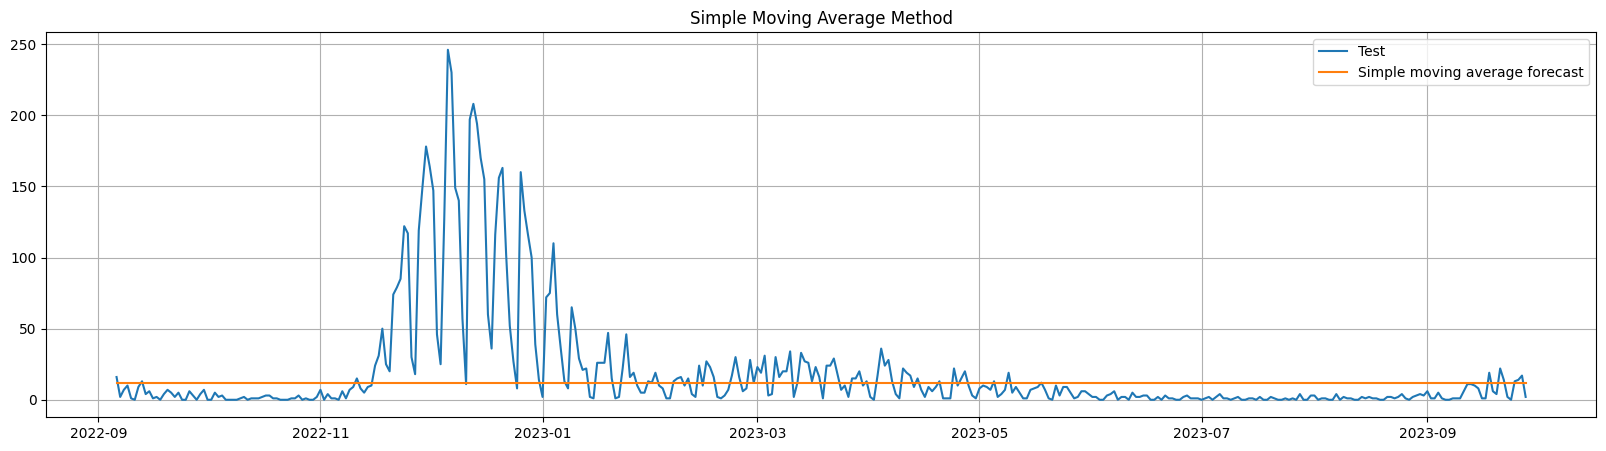

In [8]:
janela = range(1, 20)

train = df[:split]
test = df[split:]

mseMM = []
rmseMM = []
maeMM = []
parametrosMM = []
auxMae = 0


for j in range(20):

    maeCalibra = 0
    auxMae = 0
    ## CALIBRAR
    for i in janela:
        media_movel = df['CasosDia'].rolling(i).mean()
        media_movel[split:] = media_movel[split-1]

        maeCalibra = mean_absolute_error(test['CasosDia'], media_movel[split:]).round(2)

        if (maeCalibra < auxMae or auxMae == 0):
            auxMae = maeCalibra
            para_MM = i



    ## TREINA
    media_movel = df['CasosDia'].rolling(para_MM).mean()
    media_movel[split:] = media_movel[split-1]

    mae = mean_absolute_error(test['CasosDia'], media_movel[split:]).round(2)
    mse = mean_squared_error(test['CasosDia'], media_movel[split:]).round(2)
    rmse = np.sqrt(mse).round(2)

    mseMM.append(mse)
    rmseMM.append(rmse)
    maeMM.append(mae)
    parametrosMM.append(para_MM)


# RESULTADOSSSS !!!!
    
parametroMaisEscolhidoMM = max(set(parametrosMM), key=parametrosMM.count)
media_maeMM = np.mean(maeMM)
media_mseMM = np.mean(mseMM)
media_rmseMM = np.mean(rmseMM)

parametrosMM.append(parametroMaisEscolhidoMM)
maeMM.append(media_maeMM)
mseMM.append(media_mseMM)
rmseMM.append(media_rmseMM)


dfMediaMovel = pd.DataFrame({
    'PARA': parametrosMM,
    'MAE': maeMM,
    'MSE': mseMM,
    'RMSE': rmseMM
})


print("!! ULTIMO VALOR (20) É A MÉDIA !!!")
display(dfMediaMovel)



plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['CasosDia'], label='Train')
plt.plot(test['CasosDia'], label='Test')
plt.plot(media_movel, label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(test['CasosDia'], label='Test')
plt.plot(media_movel[split:], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

# SUAVIZAÇÃO EXPONENCIAL - exponential-smoothing

23.24
23.24
!! ULTIMO VALOR (20) É A MÉDIA !!!


,PARA,MAE,MSE,RMSE
0,0.1,23.24,1556.21,39.45
1,0.1,23.24,1556.21,39.45
2,0.1,23.24,1556.21,39.45
3,0.1,23.24,1556.21,39.45
4,0.1,23.24,1556.21,39.45
5,0.1,23.24,1556.21,39.45
6,0.1,23.24,1556.21,39.45
7,0.1,23.24,1556.21,39.45
8,0.1,23.24,1556.21,39.45
9,0.1,23.24,1556.21,39.45


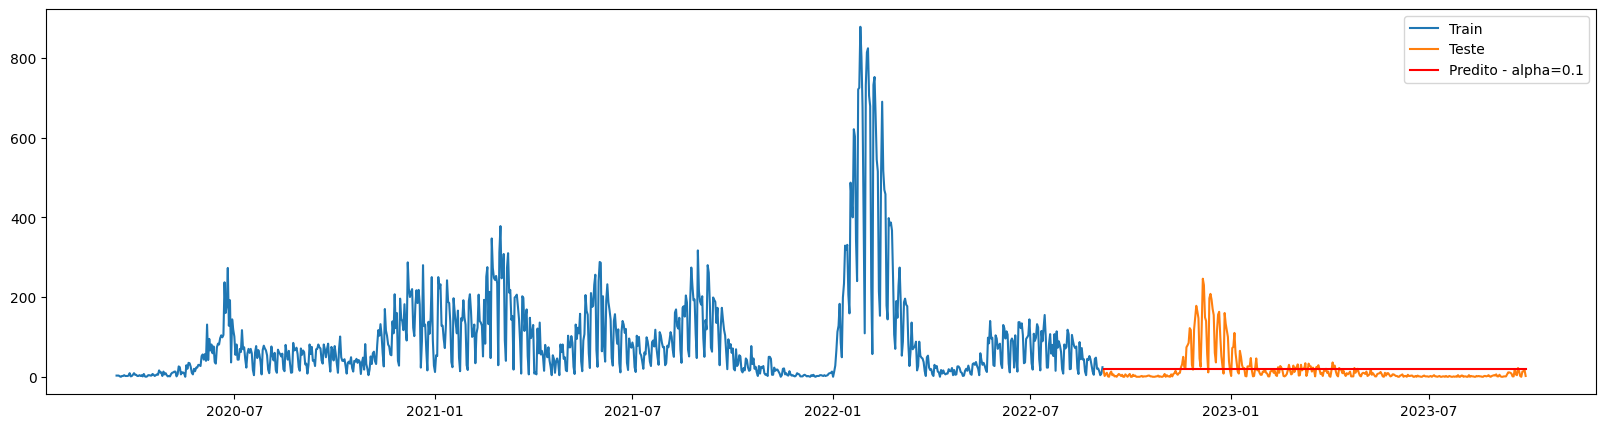

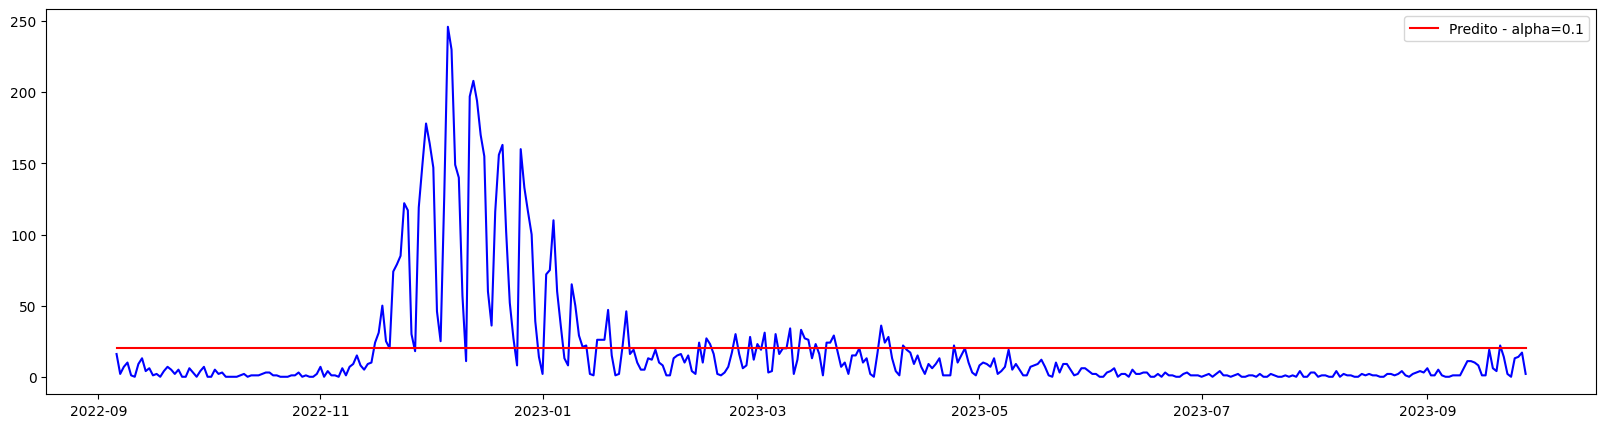

In [9]:



alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8, 0.9]

mseSE = []
rmseSE = []
maeSE = []
parametrosSE = []
auxMae = 0


for j in range(20):

    maeCalibra = 0

    ## CALIBRAR
    for i in alpha:


        #rint(X_treino)
        #print(Y_treino)

        modelo = ExponentialSmoothing(Y_treino).fit(smoothing_level=0.2)
        pred = modelo.forecast(len(Y_teste))

        maeCalibra = mean_absolute_error(Y_teste, pred).round(2)

        if (maeCalibra < auxMae or auxMae == 0):
            auxMae = maeCalibra
            print(maeCalibra)
            print(auxMae)
            para_SE = i




    ## TREINA
    modelo = ExponentialSmoothing(Y_treino).fit(smoothing_level=0.2)
    pred = modelo.forecast(len(Y_teste))

    mae = mean_absolute_error(Y_teste, pred).round(2)
    mse = mean_squared_error(Y_teste, pred).round(2)
    rmse = np.sqrt(mse).round(2)

    mseSE.append(mse)
    rmseSE.append(rmse)
    maeSE.append(mae)
    parametrosSE.append(para_SE)


# RESULTADOSSSS !!!!
    
parametroMaisEscolhidoSE = max(set(parametrosSE), key=parametrosSE.count)
media_maeSE = np.mean(maeSE)
media_mseSE = np.mean(mseSE)
media_rmseSE = np.mean(rmseSE)

parametrosSE.append(parametroMaisEscolhidoSE)
maeSE.append(media_maeSE)
mseSE.append(media_mseSE)
rmseSE.append(media_rmseSE)


dfSuaviExpo = pd.DataFrame({
    'PARA': parametrosSE,
    'MAE': maeSE,
    'MSE': mseSE,
    'RMSE': rmseSE
})


print("!! ULTIMO VALOR (20) É A MÉDIA !!!")
display(dfSuaviExpo)

plt.figure(figsize=(20,5))
plt.plot(train['CasosDia'], label='Train')
plt.plot(test['CasosDia'], label='Teste')
plt.plot(X_teste, pred, color='red',label=('Predito - alpha=' + str(para_SE)))
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.plot(X_teste, Y_teste, color='blue')
plt.plot(X_teste, pred, color='red',label=('Predito - alpha=' + str(para_SE)))
plt.legend()
plt.show()






# ARIMA


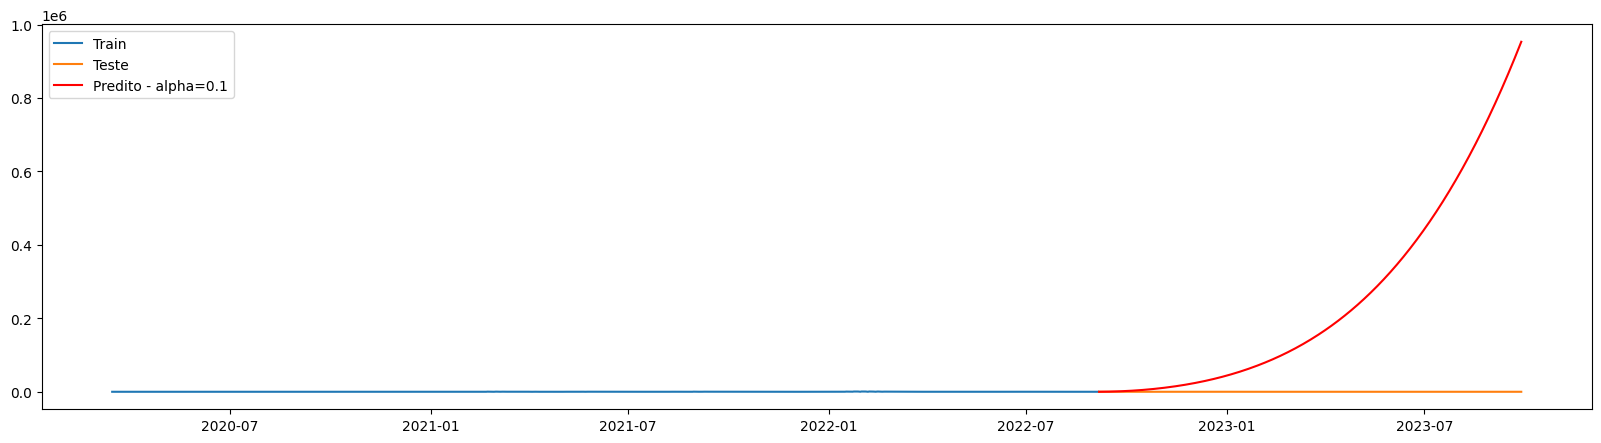

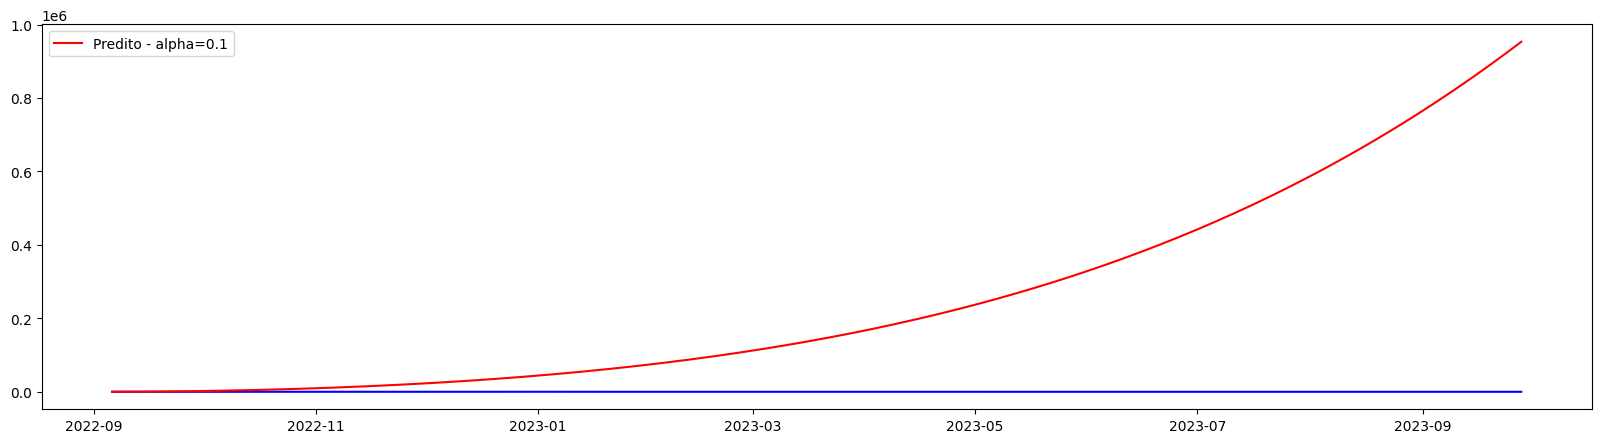

In [16]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(5,5,5))
model_fit = model.fit()
pred = model_fit.forecast(steps=len(Y_teste))

plt.figure(figsize=(20,5))
plt.plot(train['CasosDia'], label='Train')
plt.plot(test['CasosDia'], label='Teste')
plt.plot(X_teste, pred, color='red',label=('Predito - alpha=' + str(para_SE)))
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.plot(X_teste, Y_teste, color='blue')
plt.plot(X_teste, pred, color='red',label=('Predito - alpha=' + str(para_SE)))
plt.legend()
plt.show()


In [ ]:


mseARIMA = []
rmseARIMA = []
maeARIMA = []

parametroP_ARIMA = []
parametroD_ARIMA = []
parametroQ_ARIMA = []
auxMae = 0

parametro_p = [0,1,2,3,4,5]
parametro_d = [0,1,2,3,4,5]
parametro_q = [3,4,5,6,7,8,9,10]


for j in range(20):

    maeCalibra = 0
    auxMae = 0
    ## CALIBRAR
    for p in parametro_p:
      for d in parametro_d:
        for q in parametro_q:
            model = ARIMA(train, order=(p,d,q))
            model_fit = model.fit()
            pred = model_fit.forecast(steps=len(Y_teste))


            maeCalibra = mean_absolute_error(Y_teste, pred).round(2)

            if (maeCalibra < auxMae or auxMae == 0):
                auxMae = maeCalibra
                para_p = p
                para_d = d
                para_q = q



    ## TREINA
    model = ARIMA(train, order=(para_p,para_d,para_q))
    model_fit = model.fit()
    pred = model_fit.forecast(steps=len(Y_teste))

    mae = mean_absolute_error(Y_teste, pred).round(2)
    mse = mean_squared_error(Y_teste, pred).round(2)
    rmse = np.sqrt(mse).round(2)

    mseARIMA.append(mse)
    rmseARIMA.append(rmse)
    maeARIMA.append(mae)

    parametroP_ARIMA.append(para_p)
    parametroD_ARIMA.append(para_d)
    parametroQ_ARIMA.append(para_q)


# RESULTADOSSSS !!!!
    
parametroMaisEscolhidoARIMA = max(set(parametrosARIMA), key=parametrosARIMA.count)
media_maeARIMA = np.mean(maeARIMA)
media_mseARIMA = np.mean(mseARIMA)
media_rmseARIMA = np.mean(rmseARIMA)

parametrosARIMA.append(parametroMaisEscolhidoARIMA)
maeARIMA.append(media_maeARIMA)
mseARIMA.append(media_mseARIMA)
rmseARIMA.append(media_rmseARIMA)


dfMediaMovel = pd.DataFrame({
    'PARA': parametrosARIMA,
    'MAE': maeARIMA,
    'MSE': mseARIMA,
    'RMSE': rmseARIMA
})


print("!! ULTIMO VALOR (20) É A MÉDIA !!!")
display(dfMediaMovel)



plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['CasosDia'], label='Train')
plt.plot(test['CasosDia'], label='Test')
plt.plot(media_movel, label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(test['CasosDia'], label='Test')
plt.plot(media_movel[split:], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

## Para modelos de AM - Casos, chuva soma, umidade e temp media + deslocamento ()